In [1]:
import numpy as np
import pandas as pd
from nptdms import TdmsFile
from scipy.signal import welch, stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import librosa
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
random_state = 2137

tdms_file = TdmsFile.read(r'DataFileKotwalipiec23_pociete_Gora_Dol_Zalom.tdms')
#dane=tdms_file.as_dataframe(time_index=False, absolute_time=False, scaled_data=True)

kotwa_ids = []
rodzaj_id = []
wzbudzenia = []
podjazd =[]

for group in tdms_file.groups():
    for channel in group.channels():
        data_len = np.shape(channel.data)[0]
        if(data_len<=1000000 and data_len>=10000 and channel.name[0]!='Z'):
            kotwa_ids.append(group.name)
            rodzaj_id.append(channel.name[0])
            podjazd.append(channel.name[2:])
            wzbudzenia.append(channel.data)

            #print(channel.name[2:])
            #print(np.shape(channel.data))




In [2]:
print(rodzaj_id)
#przyjęte że gora i zalom to ten sam rodzaj oznaczone 0, dol oznaczone 1, zalom odrzucony wyżej
rodzaj_klasyfikacja=[1 if elem == 'D' else 0 for elem in rodzaj_id]
print(rodzaj_klasyfikacja)

['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


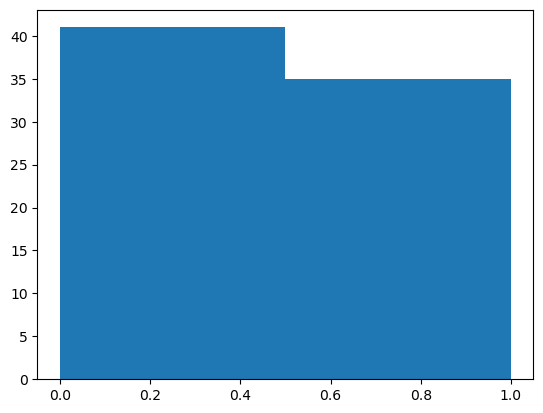

(76,)
[41 35]


In [3]:
plt.figure()
plt.hist(rodzaj_klasyfikacja, 2)
plt.show()

print(np.shape(rodzaj_klasyfikacja))

values, counts = np.unique(rodzaj_klasyfikacja, return_counts=True)
data_len = np.shape(rodzaj_klasyfikacja)[0]
print(counts)

In [4]:
widma = []
mfccs_all = []
stft_amplitudes = []
stft_phases = []
fs = 50000

longest = 0
for signal in wzbudzenia:
    if(np.shape(signal)[0]>longest): longest = np.shape(signal)[0]

for signal in tqdm(wzbudzenia):
    padded = np.pad(signal, (0,longest-np.shape(signal)[0]), mode="constant", constant_values=0)

    # mfccs = librosa.feature.mfcc(y=padded, sr=fs, n_mfcc=30)
    # mfccs_all.append(mfccs)

    # d = librosa.stft(y = padded)
    # stft_amplitudes.append(np.abs(d))
    # stft_phases.append(np.angle(d))

    f, pxx = welch(padded, fs, nperseg=40000)
    widma.append(pxx)
    # print(f[np.argmax(pxx)])



100%|██████████| 76/76 [00:00<00:00, 751.79it/s]


(76, 20001)


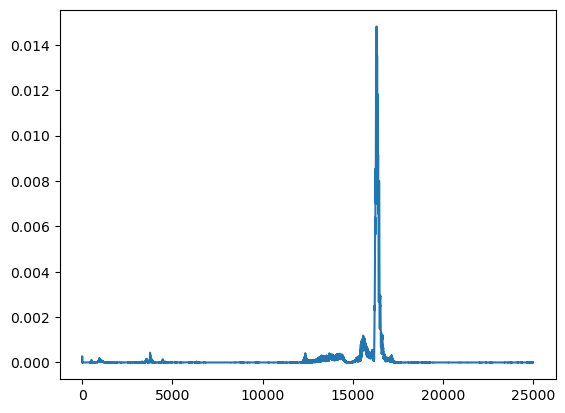

5965
74121


In [5]:
widmanp = np.asarray(widma)
print(np.shape(widmanp))

plt.figure()
plt.plot(f, widma[0])
plt.show()
print(np.argmax(widma[7]))
# print(f[np.argmax(widma[7])])
print(longest)

# fig, ax = plt.subplots()
# img = librosa.display.specshow(librosa.amplitude_to_db(stft_phases[4], ref=np.max), y_axis='log', x_axis='time', ax=ax)
# ax.set_title('Power spectrogram')
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(widmanp, np.asarray(rodzaj_klasyfikacja), test_size=0.3, stratify=rodzaj_klasyfikacja, random_state=random_state)

In [7]:
class_weight = {0: 1/counts[0]*(data_len/2), 1:1/counts[1]*(data_len/2)}

Sieć 1 na PSD

In [8]:
def create_psd_classification_model(input_dim):
    model = Sequential([
        Dense(1000, activation='relu', input_dim=input_dim),
        # Dense(256, activation='relu'),
        # Dense(128, activation='relu'),
        #Dropout(0.5),
        Dense(1000, activation='relu'),
        #Dropout(0.5),
        Dense(1000, activation='relu'),
        #Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# Get the number of features from your data
num_features = x_train.shape[1]

# Create the model
psd_model = create_psd_classification_model(num_features)

initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
psd_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history=psd_model.fit(x_train, y_train, 
                      epochs=100, 
                      batch_size=8, 
                      validation_split=0.2, 
                      class_weight=class_weight
                      ,
                      callbacks=[reduce_lr, early_stopping]
                    )

# Evaluate the model on the test set
result = psd_model.evaluate(x_test, y_test)
print(f'Test Loss: {result[0]}, Test Accuracy: {result[2]}')



Epoch 1/100


6/6 [==============================] - 2s 184ms/step - loss: 0.6951 - binary_crossentropy: 0.6947 - accuracy: 0.5714 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 145ms/step - loss: 0.6897 - binary_crossentropy: 0.6898 - accuracy: 0.5714 - val_loss: 0.6798 - val_binary_crossentropy: 0.6798 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 142ms/step - loss: 0.6793 - binary_crossentropy: 0.6808 - accuracy: 0.8095 - val_loss: 0.6305 - val_binary_crossentropy: 0.6305 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 146ms/step - loss: 0.6299 - binary_crossentropy: 0.6272 - accuracy: 0.7619 - val_loss: 0.4813 - val_binary_crossentropy: 0.4813 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 1s 143ms/step - loss: 0.5181 - binary_crossentropy: 0.5231 - accuracy: 0.

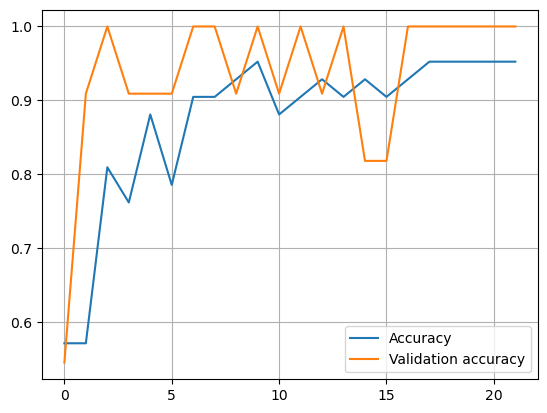

In [10]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Accuracy", "Validation accuracy"])
plt.grid()
plt.show()


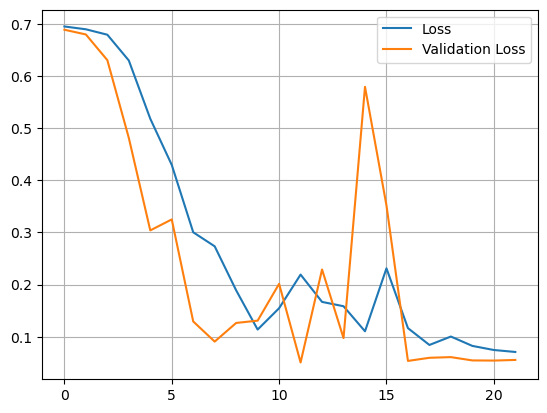

In [11]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss", "Validation Loss"])
plt.grid()
plt.show()

KFOLD

In [14]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=8, shuffle=True)
acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(widmanp, np.asarray(rodzaj_klasyfikacja)):
    
    model_temp = create_psd_classification_model(num_features)
    model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model_temp.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.3, class_weight=class_weight, verbose=0)
    scores = model_temp.evaluate(widmanp[test], np.asarray(rodzaj_klasyfikacja)[test], verbose=0)
    print(f'Score for fold {fold_no}: {model_temp.metrics_names[0]} of {scores[0]}; {model_temp.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


Score for fold 1: loss of 0.4171942174434662; accuracy of 89.99999761581421%
Score for fold 2: loss of 0.011351173743605614; accuracy of 100.0%
Score for fold 3: loss of 0.12878909707069397; accuracy of 89.99999761581421%
Score for fold 4: loss of 0.001013611676171422; accuracy of 100.0%
Score for fold 5: loss of 1.4727270603179932; accuracy of 66.66666865348816%
Score for fold 6: loss of 0.007288925349712372; accuracy of 100.0%
Score for fold 7: loss of 1.076330304145813; accuracy of 88.88888955116272%
Score for fold 8: loss of 2.2325010299682617; accuracy of 77.77777910232544%
